In [1]:
import sys
from pathlib import Path

# Add src/ to Python path
project_root = Path.cwd().parent  # assuming notebook is inside notebooks/
sys.path.insert(0, str(project_root))


In [2]:
import yaml

import src.data_src.point_data_sources as pds
import src.data_src.gridded_data_sources as gds
import src.utils.data_utils as data_utils
from src.utils.grid_utils import Grid


# %% Point data sources
def load_point_data_source(filepath, secondary_id):
    if secondary_id in ['2020-2021', '2021-2022']:
        return pds.C2I.C2I(filepath, secondary_id=secondary_id)
    elif secondary_id == 'IDCSI4':
        return pds.OIB.OIB(filepath)
    elif secondary_id == 'ICEBIRD':
        return pds.AEM_AWI.AEM_AWI_ICEBIRD(filepath)
    elif secondary_id == 'PARARCMIP':
        return pds.AEM_AWI.AEM_AWI_PARARCMIP(filepath)
    else:
        raise ValueError(f"Unsupported secondary_id: {secondary_id}")


def grid_and_merge_point_data_sources(sources, target_grid_id):
    gridded_sources = []
    for source in sources:
        gridded_sources.append(source.resample_bucket(target_grid_id))
    
    # Merge all gridded sources into one
    return pds.base.GriddedPointDataSource.merge_sources(gridded_sources)


# %% Gridded data sources
def load_CETB_channels(CETB_mapping, date, grid, channels=None):
    files = CETB_mapping[date]
    if channels is not None:
        channel_files = [f for f in files if Path(f).stem.split('_')[7] in channels]
    else:
        channel_files = files

    cetb_scenes = []
    for file in channel_files:
        cetb_scene = gds.CETBScene.from_files([file])
        cetb_scene.regrid(grid)
        cetb_scenes.append(cetb_scene)
    
    cetb_ds = gds.GriddedDataSource.merge(cetb_scenes)
    return cetb_ds

def load_ERA5_data(ERA5_mapping, date, grid, variables = None):
    ERA5_dict = yaml.safe_load(open('config/ERA5_variables.yaml'))
    files = ERA5_mapping[date]
    if variables is not None:
        variable_files = [f for f in files if ERA5_dict[var]['filename'] in f for var in variables]
    else:
        variable_files = files

    era5_ds = gds.ERA5Scene.from_files(variable_files)
    era5_ds.regrid(grid)
    return era5_ds

In [9]:
CETB_mapping = data_utils.map_CETB_file_dates(r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\raw\CETB_AMSR2")
ERA5_mapping = data_utils.map_ERA5_file_dates(r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\ASP_predictor\data\raw\ERA5_all-param_daily_perMonth_1hourly-sample")

In [12]:
ERA5_mapping[date(2020, 11, 15)]

KeyError: (2020, 11)

In [4]:
from datetime import date

grid = Grid.from_predefined('EASE2_N3.125km')
ds = load_CETB_channels(CETB_mapping, date(2020, 11, 15),grid=grid)

In [5]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 1, y: 5760, x: 5760)
Coordinates:
  * time     (time) datetime64[ns] 8B 2020-11-15
  * y        (y) float64 46kB 8.998e+06 8.995e+06 ... -8.995e+06 -8.998e+06
  * x        (x) float64 46kB -8.998e+06 -8.995e+06 ... 8.995e+06 8.998e+06
Data variables:
    10.7H    (time, y, x) float32 133MB dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    10.7V    (time, y, x) float32 133MB dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    6.9H     (time, y, x) float32 133MB dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    6.9V     (time, y, x) float32 133MB dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    36H      (time, y, x) float32 133MB dask.array<chunksize=(1, 1440, 1440), meta=np.ndarray>
    36V      (time, y, x) float32 133MB dask.array<chunksize=(1, 1440, 1440), meta=np.ndarray>
    89H      (time, y, x) float32 133MB dask.array<chunksize=(1, 1440, 1440), meta=np.ndarray>
    89V      (time, y, x) float32 133MB dask.array<chunksize=(1, 1440, 1440), meta=np.ndarray>
    18H      (time, y, x) float32 133MB dask.array<chunksize=(1, 1440, 5760), meta=np.ndarray>
    18V      (time, y, x) float32 133MB dask.array<chunksize=(1, 1440, 5760), meta=np.ndarray>
    23H      (time, y, x) float32 133MB dask.array<chunksize=(1, 1440, 5760), meta=np.ndarray>
    23V      (time, y, x) float32 133MB dask.array<chunksize=(1, 1440, 5760), meta=np.ndarray>

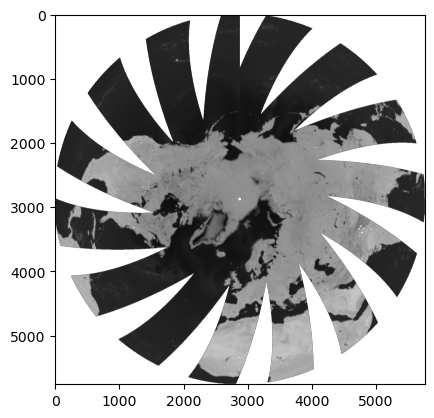

In [8]:
import matplotlib.pyplot as plt
plt.imshow(ds.data['6.9V'].isel(time=0), cmap='gray')